## Visualization (Real landscapes with heterogeneous fuels)
Visualization code to plot real landscapes in the US, Canada, and Chile
- US: Landscape taken from the Sherpa Fire region (Southern California near Santa Barbara)
- Canada: Landscape from the Dogrib Fire region (Near Alberta)
- KITRAL: Landscape from the Portuzeuelo fire

In [1]:
import os, glob, warnings
from plot_utils import *
import numpy as np
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

warnings.filterwarnings("ignore")

## 1. BehavePlus (US)
Plot landscape where Sherpa fire occurred

In [5]:
def compare_real(base_path, grid1, grid2, real_df, prefire_img_path, lcp_img_path, lcp_lut_path, summary_csv_path, x_size, y_size, save=False):

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(45, 25))

    # Adjust subplots to make them equal sizes
    gs = gridspec.GridSpec(3,3, left=0.1, right=.9, bottom=0.1, top=.9, wspace=0.22, hspace=0.18,
                        width_ratios=[1,1,1], height_ratios=[1,1,0.8])
    
    a0=plt.subplot(gs[0,0]);a1=plt.subplot(gs[0,1]);a2=plt.subplot(gs[0,2]);
    a3=plt.subplot(gs[1,0]);a4=plt.subplot(gs[1,1]);a5=plt.subplot(gs[1,2]);
    a6=plt.subplot(gs[2,0]);a7=plt.subplot(gs[2,1]);a8=plt.subplot(gs[2,2]);

    ### 1. Plot true-color image (Landsat-8) of pre-fire landscape
    with rasterio.open(prefire_img_path, 'r') as src:
        b,g,r,n = src.read([1,2,3,4])        
    img = np.dstack((r,g,b))

    # Ignition Point
    ig_pt=Point(125,44) # Column, Row   
    
    # Plot
    a0.imshow(clip(img,2))

    # Add ignition point, scale bar, legend, and adjust extents
    a0.scatter(ig_pt.x, ig_pt.y, color='red', marker='*',s=400, label='Ignition')
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, height_fraction=0.02, frameon=True, location='lower right', label='Scale', font_properties={"size": 20})
    a0.add_artist(scalebar)    
    a0.set_xlim([50,275]); a0.set_ylim([150,0])
    a0.set_xticklabels([]);a0.set_yticklabels([])

    legend0 = a0.legend(title='Legend', title_fontsize='xx-large', fontsize=20)
    legend0.get_title().set_fontweight('bold')

    ############################################################################################################################################
    ### 2. Plot landscape fuels

    # Convert fuel numbers for colorbar visualization
    lcp = rasterio.open(lcp_img_path).read([1])[0][:150,50:275]
    lut = pd.read_csv(lcp_lut_path)
    lut_df = lut[lut['VALUE'].isin(np.unique(lcp))]

    lcp[lcp==91]=0;lcp[lcp==99]=2;lcp[lcp==101]=3;lcp[lcp==102]=4;lcp[lcp==121]=5;lcp[lcp==122]=6;lcp[lcp==141]=7;lcp[lcp==142]=8;lcp[lcp==145]=9;
    lcp[lcp==147]=10;lcp[lcp==161]=11;lcp[lcp==165]=12;lcp[lcp==181]=13;lcp[lcp==182]=14;lcp[lcp==183]=15;lcp[lcp==184]=16;lcp[lcp==186]=17;
    lcp[lcp==187]=18;lcp[lcp==188]=19;lcp[lcp==189]=20;lcp[lcp==202]=21

    # Create a custom colormap
    lcp_colors = lut_df[['RED','GREEN','BLUE']]
    lcp_colors = [(r,g,b) for r,g,b in zip(lut_df['RED'], lut_df['GREEN'], lut_df['BLUE'])]
    cmap = ListedColormap(lcp_colors)

    im = a1.imshow(lcp, cmap=cmap)
    divider = make_axes_locatable(a1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar0 = fig.colorbar(im, cax=cax, orientation='vertical',ticks=range(21))
    n_clusters=21
    cbar0.set_ticks((np.arange(n_clusters) + 0.5))
    cbar0.set_ticklabels(lut_df['FBFM40'], size=18)
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, height_fraction=0.02, frameon=True, location='lower right', label='Scale', font_properties={"size": 20})
    a1.add_artist(scalebar)
    a1.set_xticklabels([]);a1.set_yticklabels([])
    
    ############################################################################################################################################
    ### 3. Plot distribution
    num, counts = np.unique(lcp, return_counts = True)
    lut_df['counts'] = counts/sum(counts) * 100

    lut_cmap = [(r,g,b) for r,g,b in zip(lut_df['RED'], lut_df['GREEN'], lut_df['BLUE'])]

    a2.barh(lut_df['FBFM40'],lut_df['counts'],color=lut_cmap)
    a2.set_xlim([0,65])
    a2.set_xlabel("Relative proportion of pixels [%]", size=24)
    a2.set_ylabel("Fuel Model Type", size=24)
    a2.xaxis.grid(True, alpha=0.5)
    a2.tick_params(axis='x', labelsize=20)  # Adjust xticks size
    a2.tick_params(axis='y', labelsize=20)  # Adjust yticks size

    for i, value in enumerate(lut_df['counts']):
        value_str = f'{value:.2f}' + '%'  # Convert value to string
        a2.annotate(value_str, xy=(value, i), xytext=(value + 1, i),
                         ha='left', va='center', size=20)

    ############################################################################################################################################
    ### 4. Plot Cell2FireML & FARSITE

    a3.set_xlim([50,275]); a3.set_ylim([150,0])

    # Plot the wind field using quiver plot
    x = np.linspace(0, x_size, int(x_size/10))
    y = np.linspace(0, y_size, int(y_size/10))
    X, Y = np.meshgrid(x, y)
    U = np.ones_like(X)  # Constant eastward wind component
    V = np.ones_like(Y)*-0.5  # No northward wind component
    a3.quiver(X, Y, U, V, color='grey', alpha=0.3, zorder=0)

    colors = [plt.cm.get_cmap("jet")(i) for i in np.linspace(0, 1, 10)]
    a3.imshow(grid1[9], cmap=plt.cm.colors.ListedColormap(['none', colors[9]]), interpolation='nearest', vmin=0, vmax=1, label= '1HR')
    a3.imshow(grid1[8], cmap=plt.cm.colors.ListedColormap(['none', colors[8]]), interpolation='nearest', vmin=0, vmax=1, label= '1HR')
    a3.imshow(grid1[7], cmap=plt.cm.colors.ListedColormap(['none', colors[7]]), interpolation='nearest', vmin=0, vmax=1, label= '1HR')
    a3.imshow(grid1[6], cmap=plt.cm.colors.ListedColormap(['none', colors[6]]), interpolation='nearest', vmin=0, vmax=1, label= '1HR')
    a3.imshow(grid1[5], cmap=plt.cm.colors.ListedColormap(['none', colors[5]]), interpolation='nearest', vmin=0, vmax=1, label= '1HR')
    a3.imshow(grid1[4], cmap=plt.cm.colors.ListedColormap(['none', colors[4]]), interpolation='nearest', vmin=0, vmax=1, label= '1HR')
    a3.imshow(grid1[3], cmap=plt.cm.colors.ListedColormap(['none', colors[3]]), interpolation='nearest', vmin=0, vmax=1, label= '2HR')
    a3.imshow(grid1[2], cmap=plt.cm.colors.ListedColormap(['none', colors[2]]), interpolation='nearest', vmin=0, vmax=1, label= '3HR')
    a3.imshow(grid1[1], cmap=plt.cm.colors.ListedColormap(['none', colors[1]]), interpolation='nearest', vmin=0, vmax=1, label= '4HR')
    a3.imshow(grid1[0], cmap=plt.cm.colors.ListedColormap(['none', colors[0]]), interpolation='nearest', vmin=0, vmax=1, label= '5HR')

    # 2b. Plot FARSITE 
    contours = farsite_contour(grid2[-1]) # Compute FARSITE perimeters
    for i, contour in enumerate(contours):
        a3.plot(contour[:, 1], contour[:, 0], linewidth=2, color='k')

    scalebar = ScaleBar(1, 'm', length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 18})
    a3.add_artist(scalebar)

    # Wind direction subplot
    inner_ax = a3.inset_axes([0.85, 0.8, 0.15, 0.2])
    inner_ax.annotate("",
                xy=(0.3,0.6),  # starting point (in axis coordinates)
                xytext=(0.6,0.3),  # ending point (in axis coordinates)
                arrowprops=dict(arrowstyle="<-",lw=2, color="black", linewidth=2))
    inner_ax.annotate("Wind", xy=(0.46, 0.7), fontsize=24, ha='center')
    inner_ax.set_xticklabels([]); inner_ax.set_yticklabels([])

    ##### Legends #####
    # Cell2FireML Legend
    cell2fireML_handles = [Patch(facecolor=colors[num], label=str(num)+'HR', edgecolor='k') for num in range(len(colors))]
    labels = [f'{i+1} H' for i in range(len(colors))]
    legend1 = a3.legend(cell2fireML_handles, labels, bbox_to_anchor=(1, 1.02), loc='upper left', 
                    title='Cell2FireML\n(Hours)', title_fontsize='xx-large', fontsize=20)
    legend1.get_title().set_fontweight('bold')

    # # FARSITE Legend
    farsite_handles = [plt.Line2D([], " ", color='k', linestyle='-', linewidth=2)] # Line handles
    farsite_labels = [f' ' for i in range(len(colors))]
    legend2 = a3.legend(farsite_handles, farsite_labels, bbox_to_anchor=(1, 0.2), loc='upper left', 
                        title='FARSITE \n(Final)', title_fontsize='xx-large', fontsize=20)
    legend2.get_title().set_fontweight('bold')
    a3.add_artist(legend1); a3.add_artist(legend2)
    a3.set_xticklabels([]);a3.set_yticklabels([])

    ############################################################################################################################################
    ### 5. Plot Comparison (Error)
    # Plot grid 2
    a4.set_xlim([50,275]); a4.set_ylim([150,0])
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 20})
    a4.add_artist(scalebar)
    a4.set_xticklabels([]);a4.set_yticklabels([])

    cmap2 = ListedColormap(['firebrick','white','royalblue'])

    diff = grid2[-1] - grid1[-1]
    im = a4.imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
    divider = make_axes_locatable(a4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    sm = plt.cm.ScalarMappable(cmap=cmap2)
    sm.set_clim(-1, 1)  # Set the color limits to match the desired values
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_ticks([2/3, 0, -2/3])
    cbar.set_ticklabels(['Underestimate','No Difference','Overestimate'],size=20, ha='center', va='center', rotation=90)  # Set custom tick labels
    cbar.ax.yaxis.set_tick_params(pad=20)


    ############################################################################################################################################
    ### 6. Fire progression graph with errors

    # Plot burn area growth comparison
    df = pd.read_csv(summary_csv_path)
    df['Hour'] = [df.iloc[i]['Instance'].split('_')[-1] for i in range(len(df))]

    num_unique_values = len(df['Instance'].unique())
    palette = sns.color_palette('RdBu_r', n_colors=num_unique_values)
    hatches = ['////', '\\\\\\\\']

    # Calculate the difference between the two plots and
    # Create a mask for overestimation and underestimation
    diff = df['AreaFarsite'] - df['AreaCell2FireML']
    overestimation_mask = diff < 0 # Cell2Fire overestimates
    underestimation_mask = diff > 0

    sns.lineplot(data=df, ax=a5, x='Hour', y='AreaCell2FireML', legend=True, color='red',
                linewidth=2, marker='o', markeredgecolor='k', palette=palette, label='Cell2FireML')
    sns.lineplot(data=df, ax=a5, x='Hour', y='AreaFarsite', color='blue',
                linewidth=2, linestyle='--', marker='s', markeredgecolor='k', palette=palette, legend=True, label='FARSITE')
    a5.fill_between(df['Hour'], df['AreaFarsite'], df['AreaCell2FireML'], where=underestimation_mask, interpolate=True, color='blue', alpha=0.3, hatch=hatches[1])
    a5.fill_between(df['Hour'], df['AreaFarsite'], df['AreaCell2FireML'], where=overestimation_mask, interpolate=True, color='red', alpha=0.3, hatch=hatches[1])

    # a5.set_title('Burn Area Progression Over Time', size=20)
    a5.set_ylabel('Burned area [m$^2$]', size=24)
    a5.set_xlabel('Elapsed time since ignition [Hours]', size=24)
    a5.tick_params(axis='x', labelsize=20)  # Adjust xticks size
    a5.tick_params(axis='y', labelsize=20)  # Adjust yticks size
    a5.grid('on', alpha=0.5)

    # Combine the labels
    labels = ['Cell2FireML', 'FARSITE', 'Underestimation', 'Overestimation']
    a5.legend(labels=labels, fontsize=24, markerscale=1.5)

    num_unique_values = len(real_df['Instance'].unique())
    colormaps = [sns.color_palette(color, n_colors=num_unique_values) for color in ['Reds', 'Blues', 'Greens', 'Oranges'] ]
    real_df['RMSE'] = np.sqrt(real_df['MSE'])
    
    sns.barplot(ax=a6, data=real_df, x="Time", y="RMSE",palette=colormaps[1])
    a6.set_xlabel("Time [Hour]", size=18)
    a6.set_ylabel("RMSE [m$^2$]", size=18)
    a6.tick_params(axis='x', labelsize=16);a6.tick_params(axis='y', labelsize=16);

    sns.barplot(ax=a7, data=real_df, x="Time", y="F1",palette=colormaps[2])
    a7.set_xlabel("Time [Hour]", size=18)
    a7.set_ylabel("F1-Score", size=18)
    a7.tick_params(axis='x', labelsize=16);a7.tick_params(axis='y', labelsize=16);

    sns.barplot(ax=a8, data=real_df, x="Time", y="SSIM",palette=colormaps[3])
    a8.set_xlabel("Time [Hour]", size=18)
    a8.set_ylabel("SSIM [%]", size=18)    
    a8.tick_params(axis='x', labelsize=16);a8.tick_params(axis='y', labelsize=16);    

    if save:
        plt.savefig(os.path.join(base_path, 'comparison_cell2fireML_farsite_v2.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
# Set base paths
base_path = '/Users/minho/Desktop/Cell2FireML/Github/plot/results/USA/sherpa'

prefire_img_path = os.path.join(base_path, 'sherpa_prefire_clipped.tif')
lcp_img_path = os.path.join(base_path, 'sherpa_lcp.tif')
lcp_lut_path = os.path.join(base_path, 'lookup_table.csv')
summary_csv_path = os.path.join(base_path, 'summary_sherpa.csv')

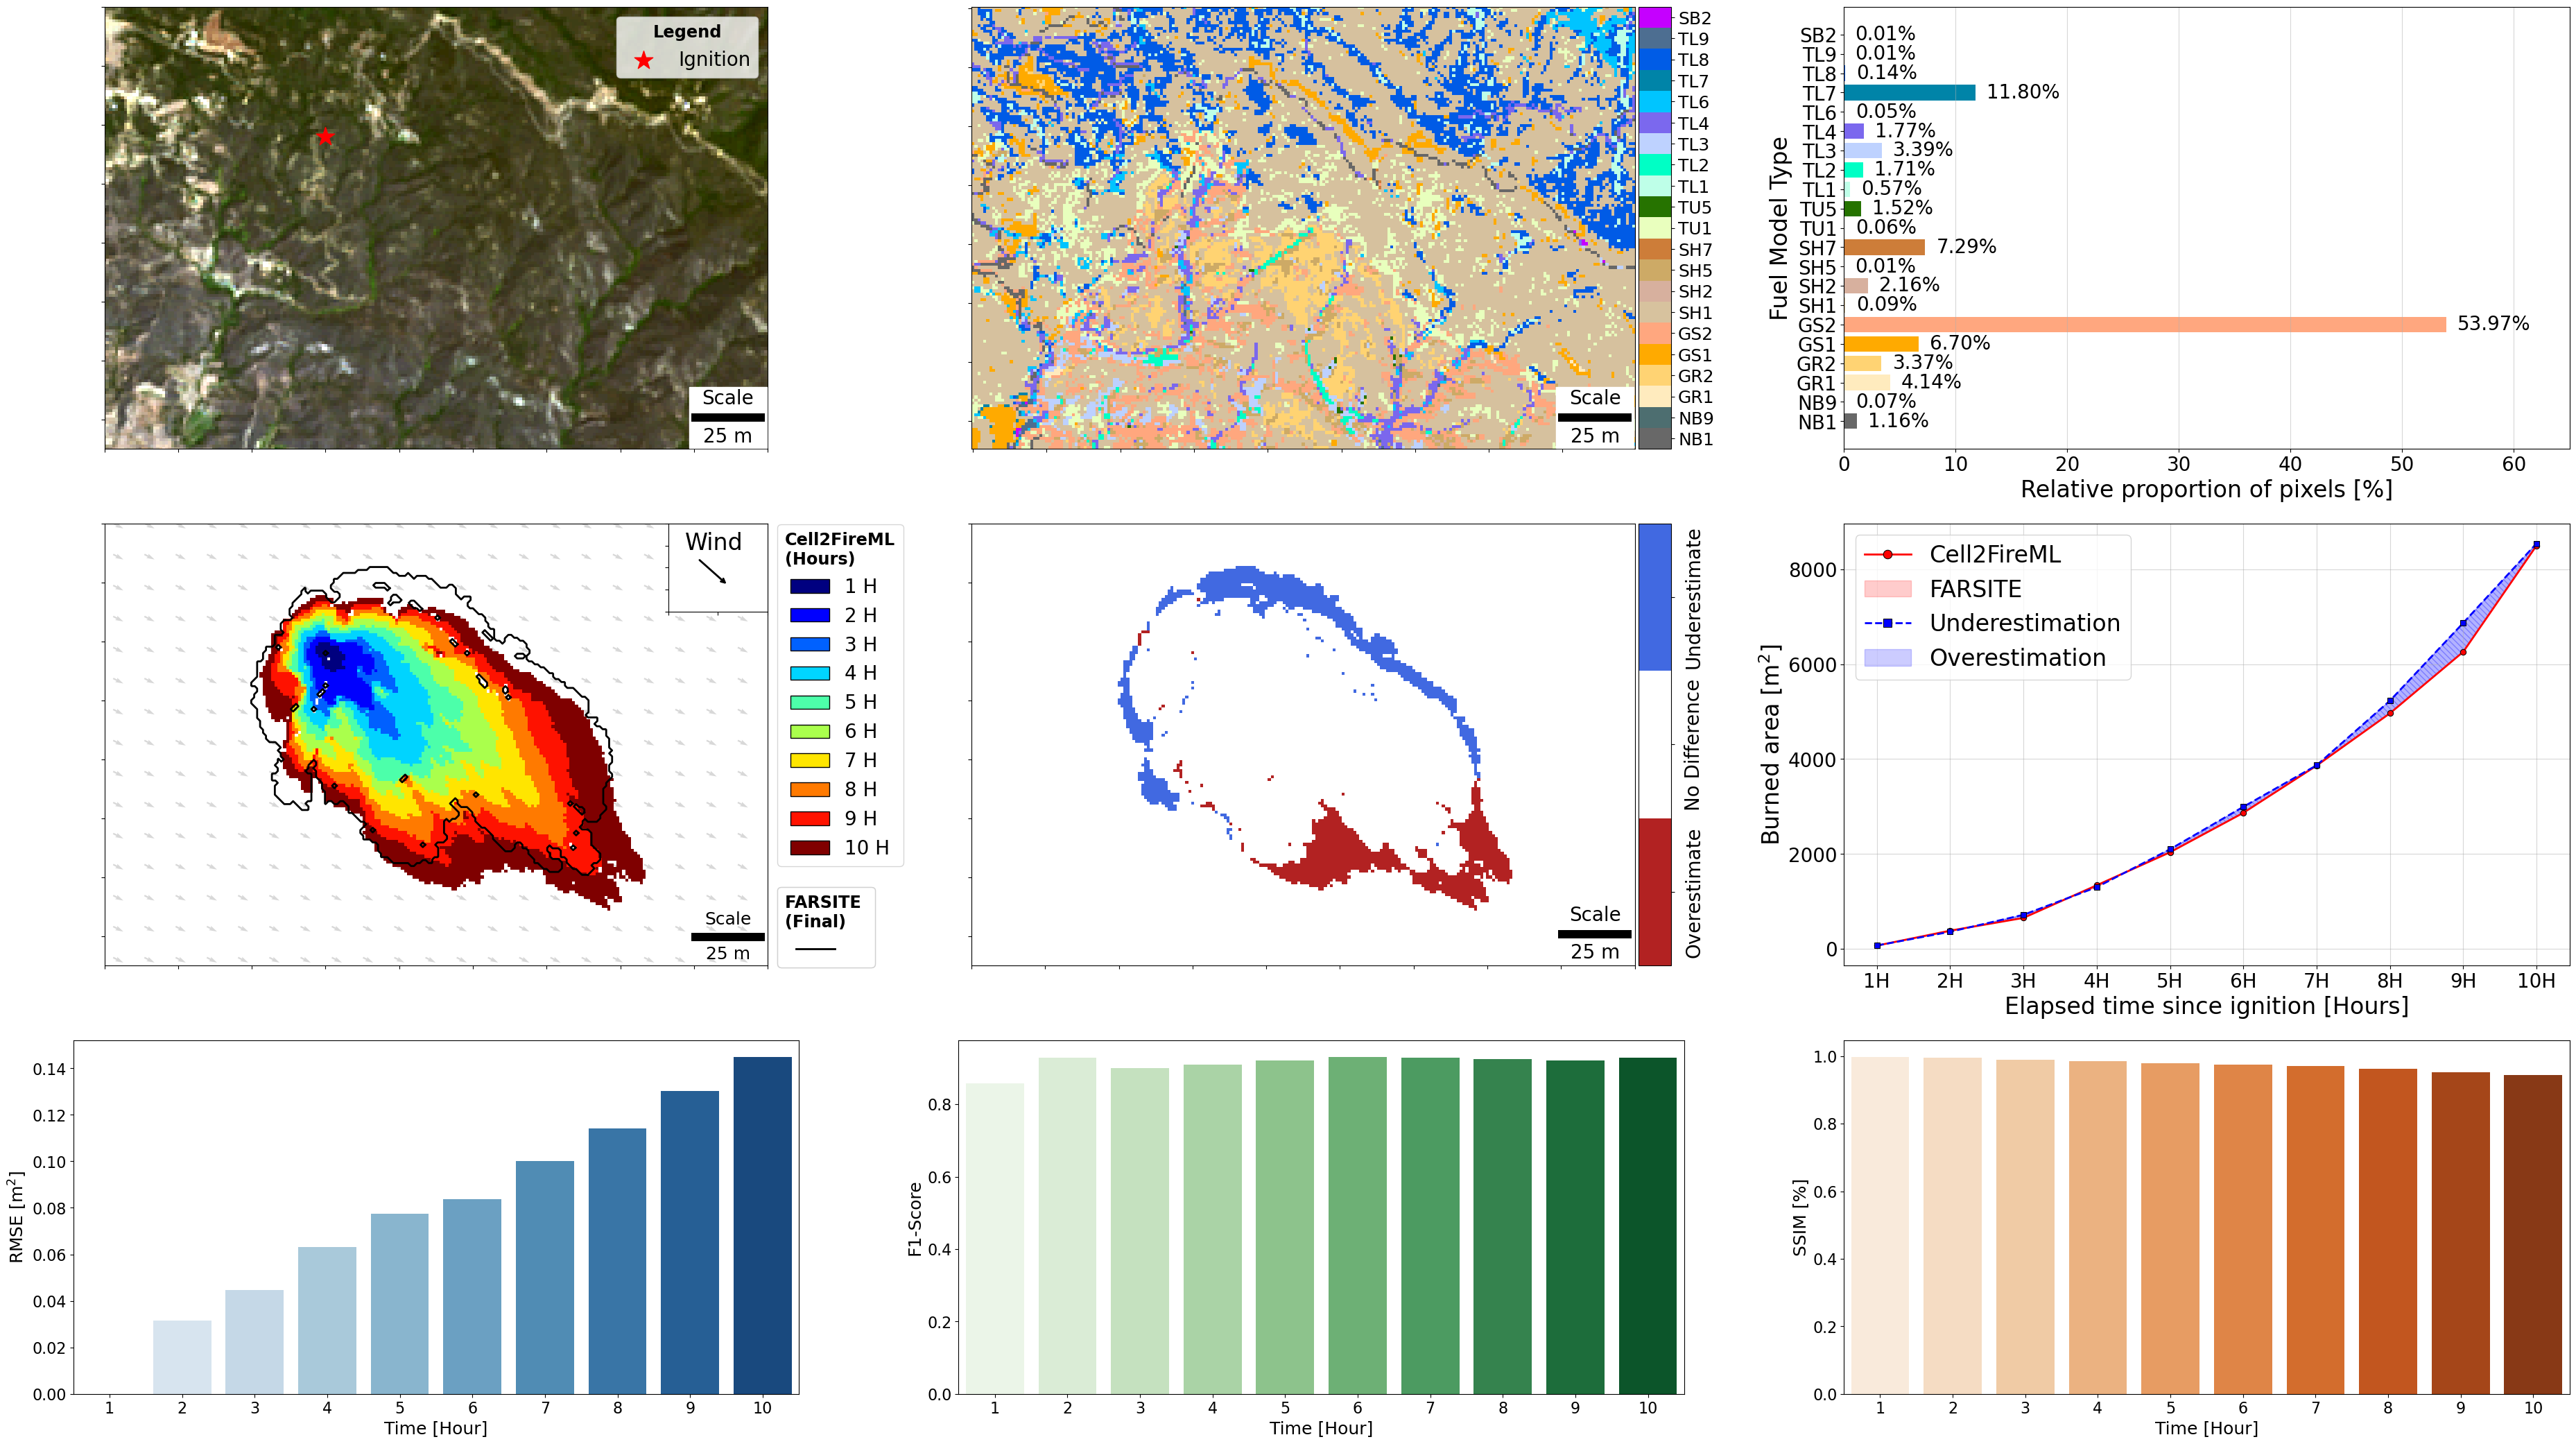

In [7]:
# Summary results for isochrones
df = pd.read_csv(os.path.join(base_path,'summary_sherpa.csv'))
df['Hour'] = [df.iloc[i]['Instance'].split('_')[-1] for i in range(len(df))]
df['Time'] = np.arange(1, len(df)+1)

# Input paths
def extract_number(directory):
    return int(directory.split('_')[-1].split('H')[0])

farsite_perim_list = sorted(glob.glob(os.path.join(base_path, 'farsite_sherpa_*.csv')))
farsite_perim_list = sorted(farsite_perim_list, key=extract_number)
c2f_perim_list = sorted(glob.glob(os.path.join(base_path, 'cell2fireml_sherpa_*.csv')))
c2f_perim_list = sorted(c2f_perim_list, key=extract_number)

# Load datasets
cell2fire_img = load_farsite_list(c2f_perim_list)
farsite_img = load_farsite_list(farsite_perim_list)

x_size,y_size = load_cell2fire(c2f_perim_list[0]).shape

compare_real(base_path = base_path, 
            grid1=cell2fire_img, 
            grid2=farsite_img, 
            real_df=df, 
            prefire_img_path=prefire_img_path, 
            lcp_img_path=lcp_img_path, 
            lcp_lut_path=lcp_lut_path, 
            summary_csv_path=summary_csv_path, 
            x_size=x_size, 
            y_size=y_size, 
            save=False)

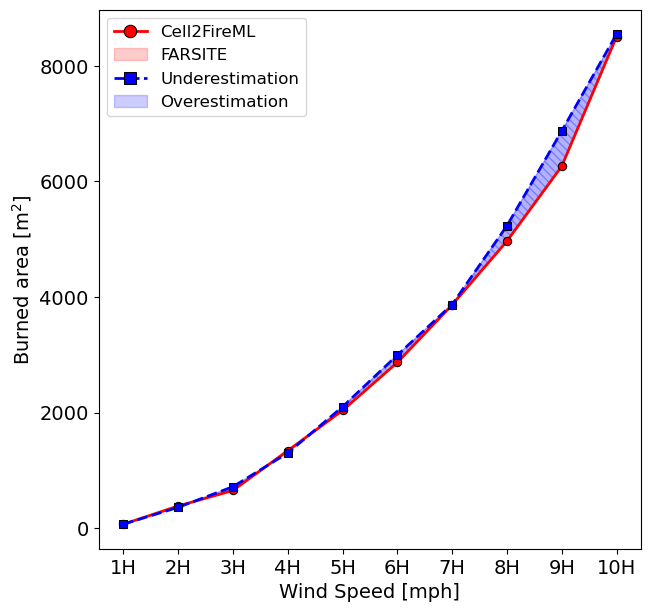

In [8]:
# Plot burn area growth comparison
fig, ax = plt.subplots(1, figsize=(7,7))

num_unique_values = len(df['Instance'].unique())
palette = sns.color_palette('RdBu_r', n_colors=num_unique_values)
hatches = ['////', '\\\\\\\\']

# Calculate the difference between the two plots and
# Create a mask for overestimation and underestimation
diff = df['AreaFarsite'] - df['AreaCell2FireML']
overestimation_mask = diff > 0
underestimation_mask = diff < 0

sns.lineplot(data=df, ax=ax, x='Hour', y='AreaCell2FireML', legend=True, color='red',
            linewidth=2, marker='o', markeredgecolor='k', palette=palette, label='Cell2FireML')
sns.lineplot(data=df, ax=ax, x='Hour', y='AreaFarsite', color='blue',
            linewidth=2, linestyle='--', marker='s', markeredgecolor='k', palette=palette, legend=True, label='FARSITE')
plt.fill_between(df['Hour'], df['AreaFarsite'], df['AreaCell2FireML'], where=overestimation_mask, interpolate=True, color='blue', alpha=0.3, hatch=hatches[1])
plt.fill_between(df['Hour'], df['AreaFarsite'], df['AreaCell2FireML'], where=underestimation_mask, interpolate=True, color='red', alpha=0.3, hatch=hatches[1])

ax.set_ylabel('Burned area [m$^2$]', size= 14)
ax.set_xlabel('Wind Speed [mph]', size=14)
ax.tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax.tick_params(axis='y', labelsize=14)  # Adjust yticks size

# Combine the labels
labels = ['Cell2FireML', 'FARSITE', 'Underestimation', 'Overestimation']
plt.legend(labels=labels, fontsize=12, markerscale=1.5)
plt.show()

## Canada

In [9]:
def compare_real(base_path, grid1, grid2, grid3, x_size, y_size, fuel_type, instance, save=False):

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(45, 20))

    # Adjust subplots to make them equal sizes
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1.05, 1.05])
    axes[0] = plt.subplot(gs[0])
    axes[1] = plt.subplot(gs[1])
    axes[2] = plt.subplot(gs[2])
    axes[3] = plt.subplot(gs[3])

    ##### Plot the wind field using quiver plot #####
    x = np.linspace(0, x_size, int(x_size/4))
    y = np.linspace(0, y_size, int(y_size/4))
    X, Y = np.meshgrid(x, y)
    U = np.ones_like(X)  # Constant eastward wind component
    V = np.zeros_like(Y)  # No northward wind component
    axes[0].quiver(X, Y, U, V, color='grey', alpha=0.3, zorder=0)

    ##### Plot PROMETHEUS #####
    axes[0].set_xlim([0,x_size]); axes[0].set_ylim([y_size,0])

    colors = ['#579c8c', '#b5e6b5', '#f7f7f7', '#ffc872', '#ff9696'] # colors = [plt.cm.get_cmap("Pastel2")(i) for i in np.linspace(0, 1, 5)]
    axes[0].imshow(grid1, cmap='Reds', interpolation='nearest', vmin=0, vmax=1, label= 'PROMETHEUS')

    # Scalebar
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 24})
    axes[0].add_artist(scalebar)

    # Wind direction subplot
    inner_ax = axes[0].inset_axes([0.85, 0.9, 0.15, 0.1])
    inner_ax.annotate("Variable\nWind", xy=(0.5, 0.2), fontsize=20, ha='center')
    inner_ax.set_xticklabels([]); inner_ax.set_yticklabels([])

    ##### Plot Cell2Fire #####
    axes[1].set_xlim([0,x_size]); axes[0].set_ylim([y_size,0])

    axes[1].imshow(grid2, cmap='Blues', interpolation='nearest', vmin=0, vmax=1, label= '5HR')

    # Scalebar
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 24})
    axes[1].add_artist(scalebar)

    # Wind direction subplot
    inner_ax = axes[1].inset_axes([0.85, 0.9, 0.15, 0.1])
    inner_ax.annotate("Variable\nWind", xy=(0.5, 0.2), fontsize=20, ha='center')
    inner_ax.set_xticklabels([]); inner_ax.set_yticklabels([])


    ###
    # Plot grid 2
    axes[2].set_xlim([0,x_size]); axes[2].set_ylim([y_size,0])
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 24})
    axes[2].add_artist(scalebar)
    cmap2 = ListedColormap(['firebrick','white','royalblue'])

    diff = grid1 - grid2
    im = axes[2].imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    sm = plt.cm.ScalarMappable(cmap=cmap2)
    sm.set_clim(-1, 1)  # Set the color limits to match the desired values
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_ticks([2/3, 0, -2/3])
    cbar.set_ticklabels(['Underestimate','No Difference','Overestimate'],size=18, ha='center', va='center', rotation=90)  # Set custom tick labels
    cbar.ax.yaxis.set_tick_params(pad=20)

    ###
    # Plot grid 2
    axes[3].set_xlim([0,x_size]); axes[3].set_ylim([y_size,0])
    scalebar = ScaleBar(1, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale', font_properties={"size": 24})
    axes[3].add_artist(scalebar)
    cmap2 = ListedColormap(['firebrick','white','royalblue'])

    diff = grid3 - grid2
    im = axes[3].imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    sm = plt.cm.ScalarMappable(cmap=cmap2)
    sm.set_clim(-1, 1)  # Set the color limits to match the desired values
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_ticks([2/3, 0, -2/3])
    cbar.set_ticklabels(['Underestimate','No Difference','Overestimate'],size=18, ha='center', va='center', rotation=90)  # Set custom tick labels
    cbar.ax.yaxis.set_tick_params(pad=20)

    fig.tight_layout()
    if save:
        plt.savefig(os.path.join(base_path, instance) + '.png', bbox_inches='tight', dpi=300)
    plt.show()

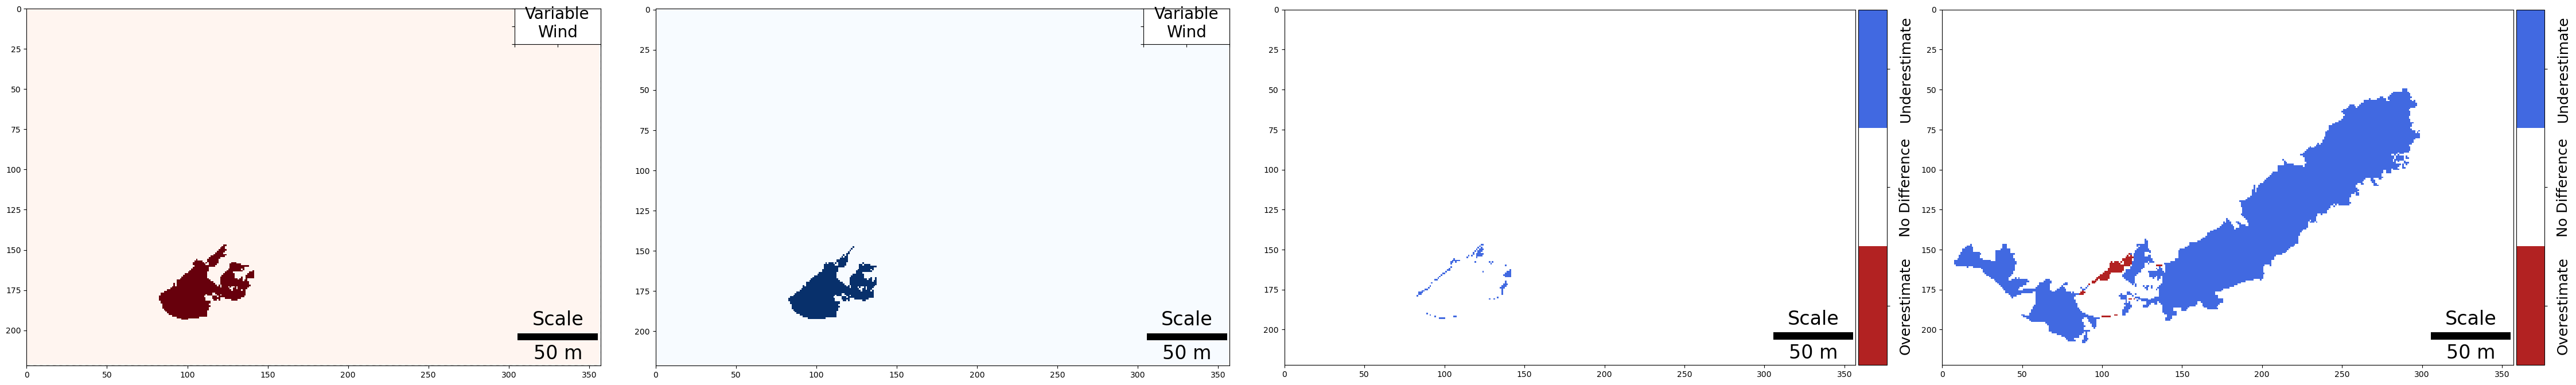

In [10]:
# Set base paths
base_path = '/Users/minho/Desktop/Cell2FireML/Github/plot/results/CANADA/'
real_path = os.path.join(base_path, 'dogrib/real_scar_dogrib.csv')
real_img = np.asarray(pd.read_csv(real_path,delimiter=' '))

# Dogrib (Short)
instance='cell2fireML_prometheus_short'
cell2fire_path = os.path.join(base_path, 'dogrib/cell2fireml_dogrib_short.csv')
prometheus_path = os.path.join(base_path, 'dogrib/prometheus_dogrib_short.csv')
cell2fire_img = np.asarray(pd.read_csv(cell2fire_path))
prometheus_img = np.asarray(pd.read_csv(prometheus_path))
compare_real(base_path=base_path, grid1=prometheus_img, grid2=cell2fire_img, grid3=real_img, x_size=prometheus_img.shape[1], y_size=prometheus_img.shape[0], fuel_type=None, instance=instance)

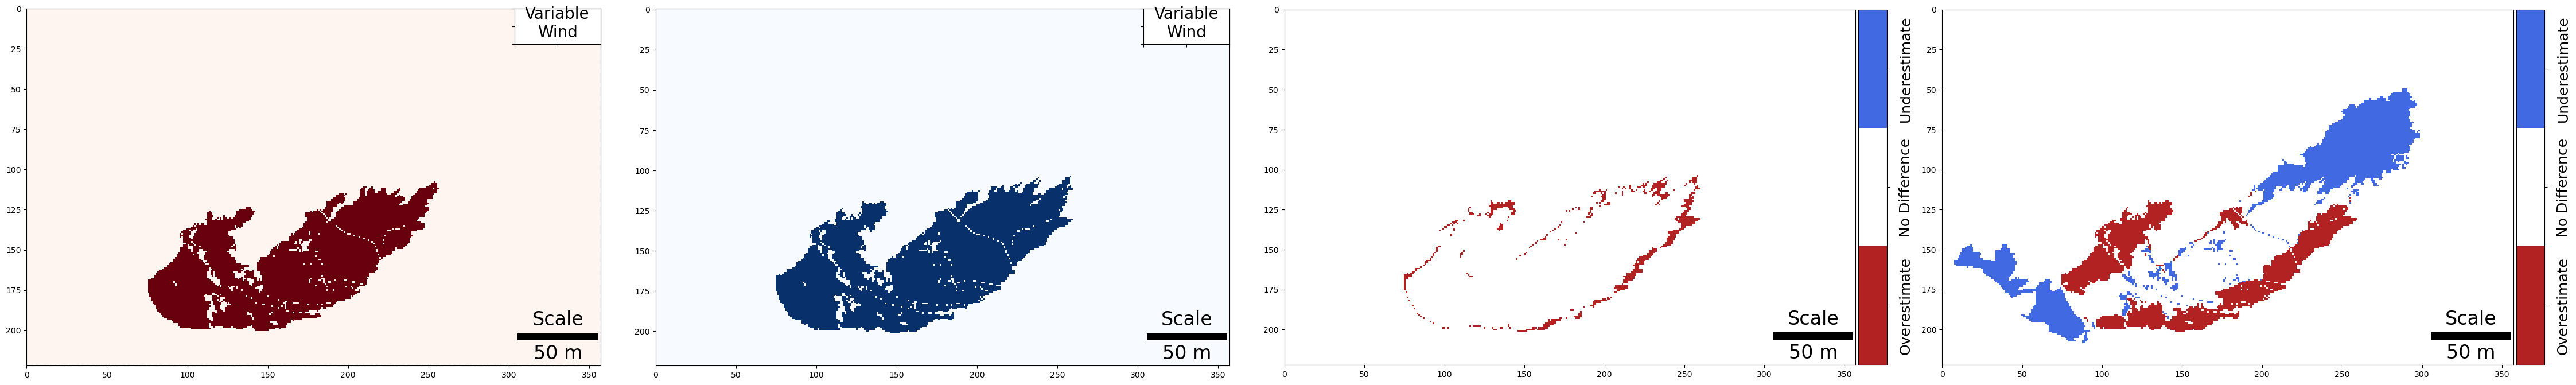

In [11]:
# Dogrib (Full)
instance='cell2fireML_prometheus_full'
cell2fire_path = os.path.join(base_path, 'dogrib/cell2fireml_dogrib_full.csv')
prometheus_path = os.path.join(base_path, 'dogrib/prometheus_dogrib_full.csv')
cell2fire_img = np.asarray(pd.read_csv(cell2fire_path))
prometheus_img = np.asarray(pd.read_csv(prometheus_path,delimiter=' '))
compare_real(base_path=base_path, grid1=prometheus_img, grid2=cell2fire_img, grid3=real_img, x_size=prometheus_img.shape[1], y_size=prometheus_img.shape[0], fuel_type=None,instance=instance)

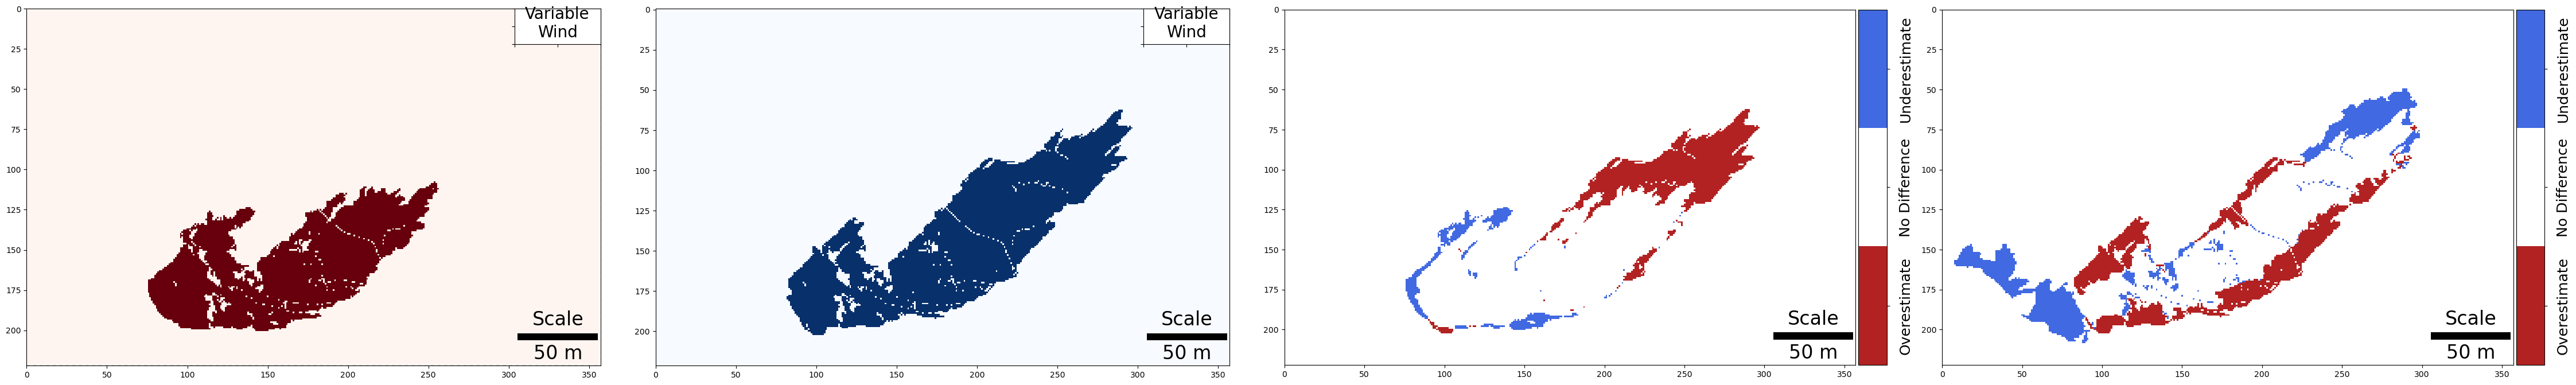

In [12]:
# Dogrib (Full + BBO)
instance='cell2fireML_prometheus_full+bbo'
cell2fire_path = os.path.join(base_path, 'dogrib/cell2fireml_dogrib_full_BBO.csv')
cell2fire_img = np.asarray(pd.read_csv(cell2fire_path))
compare_real(base_path=base_path, grid1=prometheus_img, grid2=cell2fire_img, grid3=real_img, x_size=prometheus_img.shape[1], y_size=prometheus_img.shape[0], fuel_type=None,instance=instance)

In [16]:
# Load real landscape paths
base_data_path = '/Users/minho/Desktop/Cell2FireML/Github/data/real/canada_dogrib'

forest_path = os.path.join(base_data_path, "Forest.asc")
elev_path = os.path.join(base_data_path, "elevation.asc")
slope_path = os.path.join(base_data_path, "slope.asc")
saz_path = os.path.join(base_data_path, "saz.asc")
lcp_lut_path = os.path.join(base_data_path, 'fbp_lookup_table.csv')

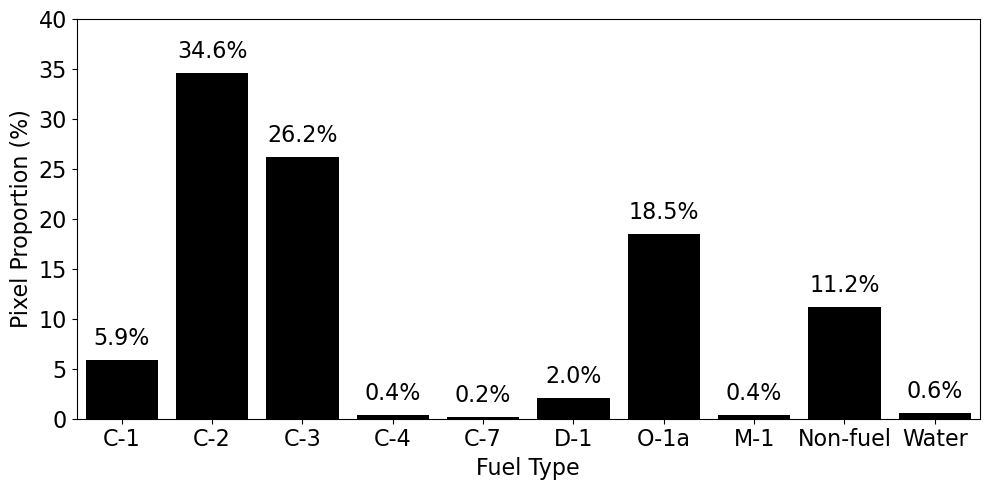

In [17]:
# Load images and LUT
forest_data = read_asc_file(forest_path)
forest_img = asc_to_numpy(forest_data)
elev_data = read_asc_file(elev_path)
elev_img = asc_to_numpy(elev_data)
slope_data = read_asc_file(slope_path)
slope_img = asc_to_numpy(slope_data)
saz_data = read_asc_file(saz_path)
saz_img = asc_to_numpy(saz_data)
lut = pd.read_csv(lcp_lut_path)
lut_df = lut[lut['grid_value'].isin(np.unique(forest_img))]

# Quantify fuel distribution
num, counts = np.unique(forest_img, return_counts=True)

lut_df = lut[lut['grid_value'].isin(np.unique(forest_img))]
lut_df['count'] = counts[1:]
lut_df['countp'] = lut_df['count']/sum(lut_df['count'])*100
lut_df['fuel_type'].iloc[-1] = "Water"

# Plot
label_size = 16

fig,ax = plt.subplots(1, figsize=(10,5))

sns.barplot(ax=ax, data=lut_df, x='fuel_type', y='countp', color='black') # Only plot up to "non-fuel"
ax.set_xlabel("Fuel Type", size=label_size)
ax.set_ylabel("Pixel Proportion (%)", size=label_size)
ax.set_ylim(0,40)
ax.tick_params(axis='x', labelsize=label_size)  # Adjust xticks size
ax.tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

for i, value in enumerate(lut_df['countp']):
    
    value_str = f'{value:.1f}' + '%'  # Convert value to string
    ax.annotate(value_str, xy=(i, value), xytext=(i, value + 1), 
                        ha='center', va='bottom', size=label_size)

plt.tight_layout()
plt.show()

In [18]:
# Cell2FireML vs FARSITE metrics
instance='cell2fireML_prometheus_homogeneous'

# Get a colormap from Matplotlib
results_df = pd.read_csv(os.path.join(base_path, 'summary_results_canada.csv'))
results_df['RMSE'] = np.sqrt(results_df['MSE'])
num_unique_values = len(results_df['FTYPE'].unique())
colormaps = [sns.color_palette(color, n_colors=num_unique_values) for color in ['Reds', 'Blues', 'Greens', 'Oranges'] ]

# Reclassify
lcp = forest_img
lcp[lcp<0] = 0
lcp[lcp==1]=0;lcp[lcp==2]=1;lcp[lcp==3]=2;lcp[lcp==4]=3;lcp[lcp==7]=4;
lcp[lcp==11]=5;lcp[lcp==31]=6;lcp[lcp==40]=7;lcp[lcp==101]=8;lcp[lcp==102]=9;

# Create a custom colormap
lcp_colors = lut_df[['r','g','b']] 
lcp_colors = [(r,g,b) for r,g,b in zip(lut_df['r']/255, lut_df['g']/255, lut_df['b']/255)]
cmap = ListedColormap(lcp_colors, name='cmap', N=len(lut_df))

# Add RMSE
results_df['RMSE'] = np.sqrt(results_df['MSE'])

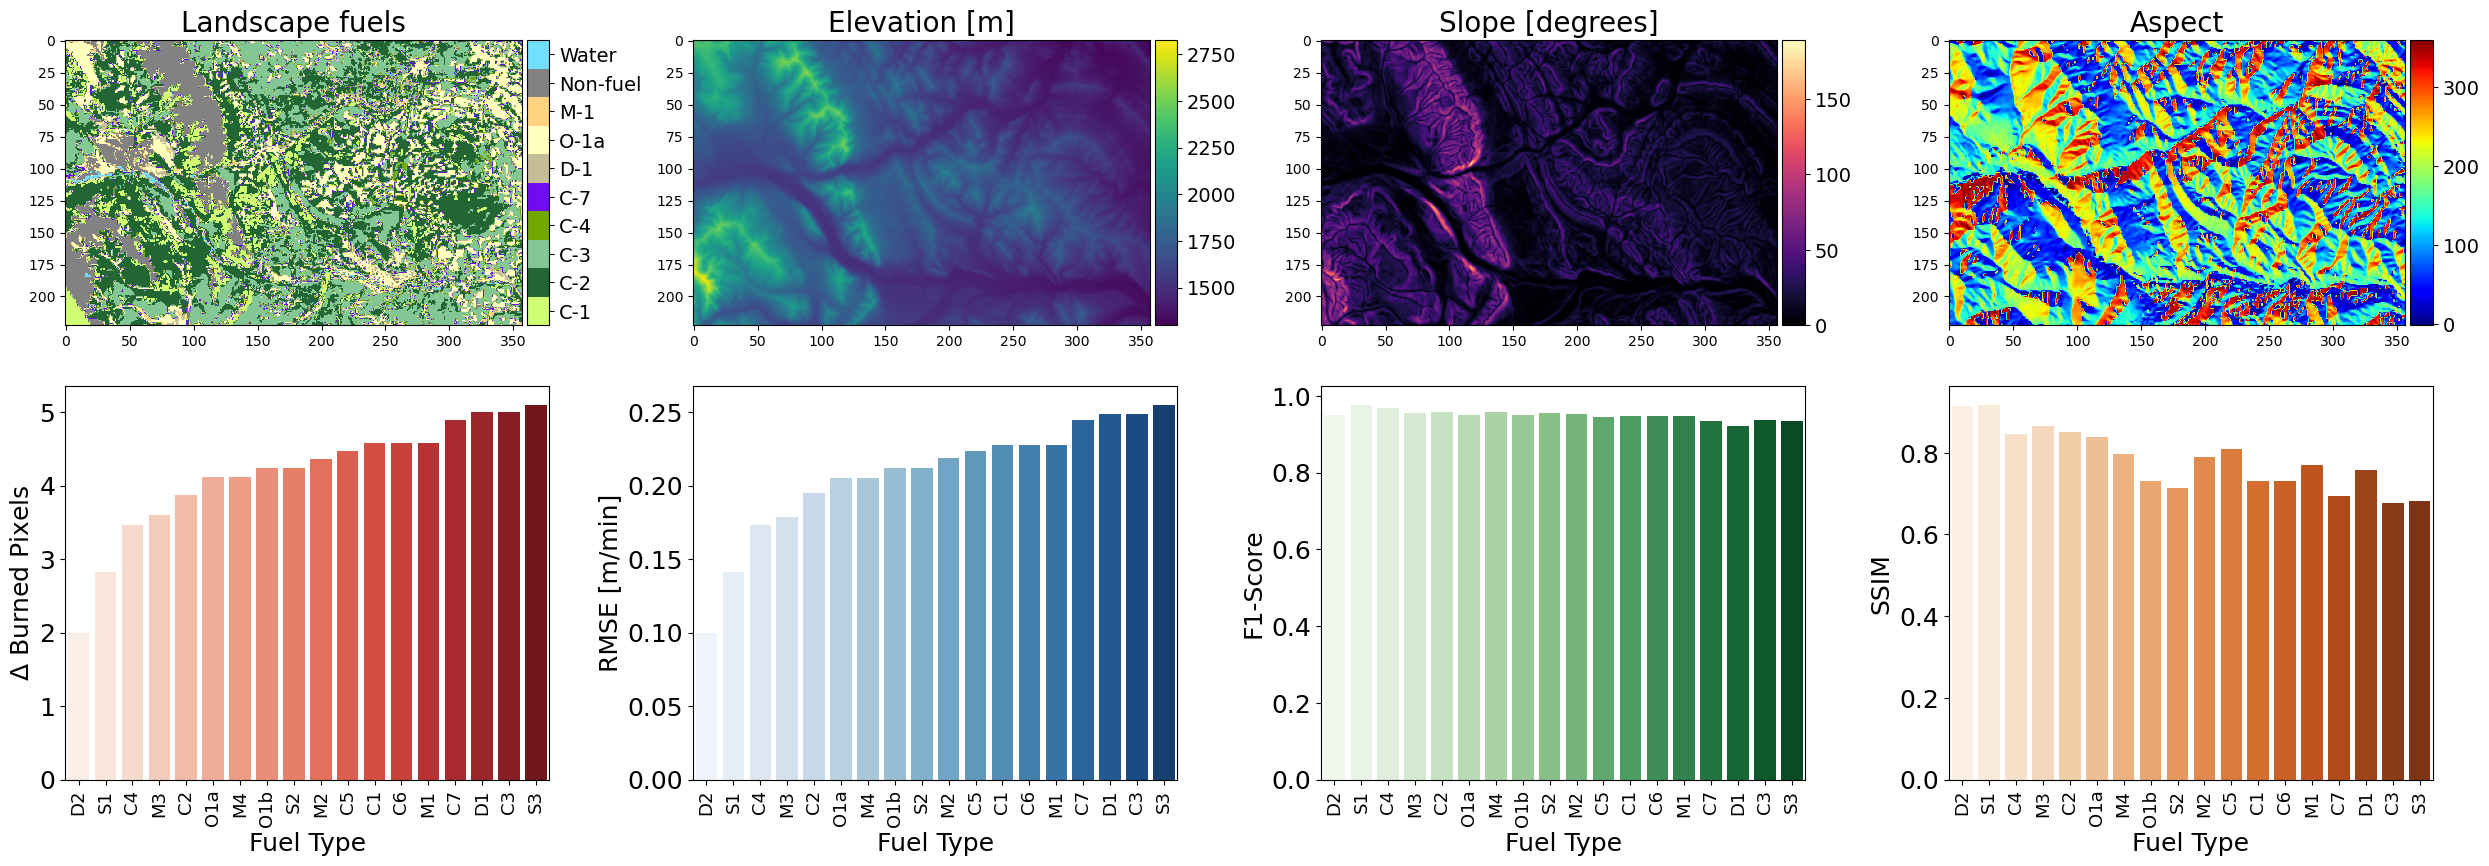

In [19]:
# Plot error and accuracy results
fig, ax = plt.subplots(2,4, figsize = (25,9))

# 1. Plot landscape
ax[0,0].imshow(lcp, cmap=cmap)
ax[0,0].set_title('Landscape fuels', size=20)
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks((np.arange(len(lcp_colors)) + 0.5) / len(lut_df))
cbar.set_ticklabels(lut_df['fuel_type'], size=14)

# 2. Plot terrain
im2 = ax[0,1].imshow(elev_img, cmap='viridis')
ax[0,1].set_title('Elevation [m]', size=20)
divider2 = make_axes_locatable(ax[0,1])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=im2.norm)
cbar2 = fig.colorbar(sm2, cax=cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=14)

im3 = ax[0,2].imshow(slope_img, cmap='magma')
ax[0,2].set_title('Slope [degrees]', size=20)
divider3 = make_axes_locatable(ax[0,2])
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
sm3 = plt.cm.ScalarMappable(cmap='magma', norm=im3.norm)
cbar3 = fig.colorbar(sm3, cax=cax3, orientation='vertical')
cbar3.ax.tick_params(labelsize=14)

im4 = ax[0,3].imshow(saz_img, cmap='jet')
ax[0,3].set_title('Aspect', size=20)
divider4 = make_axes_locatable(ax[0,3])
cax4 = divider4.append_axes('right', size='5%', pad=0.05)
sm4 = plt.cm.ScalarMappable(cmap='jet', norm=im4.norm)
cbar4 = fig.colorbar(sm4, cax=cax4, orientation='vertical')
cbar4.ax.tick_params(labelsize=14)

# 3. Plot results
real_img = np.asarray(pd.read_csv(real_path, delimiter=' '))

# Plot stats
label_size = 18

sns.barplot(ax=ax[1,0], data=results_df, x="FTYPE", y="$\delta$ norm", order=results_df.sort_values("$\delta$ norm").FTYPE, palette=colormaps[0])
ax[1,0].set_xlabel("Fuel Type", size=label_size)
ax[1,0].set_ylabel("$\Delta$ Burned Pixels", size=label_size)
ax[1,0].tick_params(axis='x', labelsize=13, rotation=90)  # Adjust xticks size
ax[1,0].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[1,1], data=results_df, x="FTYPE", y="RMSE", order=results_df.sort_values("$\delta$ norm").FTYPE, palette=colormaps[1])
ax[1,1].set_xlabel("Fuel Type", size=label_size)
ax[1,1].set_ylabel("RMSE [m/min]", size=label_size)
ax[1,1].tick_params(axis='x', labelsize=13, rotation=90)  # Adjust xticks size
ax[1,1].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[1,2], data=results_df, x="FTYPE", y="F1", order=results_df.sort_values("$\delta$ norm").FTYPE, palette=colormaps[2])
ax[1,2].set_xlabel("Fuel Type", size=label_size)
ax[1,2].set_ylabel("F1-Score", size=label_size)
ax[1,2].tick_params(axis='x', labelsize=13, rotation=90)  # Adjust xticks size
ax[1,2].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[1,3], data=results_df, x="FTYPE", y="SSIM", order=results_df.sort_values("$\delta$ norm").FTYPE, palette=colormaps[3])
ax[1,3].set_xlabel("Fuel Type", size=label_size)
ax[1,3].set_ylabel("SSIM", size=label_size)    
ax[1,3].tick_params(axis='x', labelsize=13, rotation=90)  # Adjust xticks size
ax[1,3].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

plt.tight_layout()

plt.show()

In [20]:
# Accuracy and error assessment for the Dogrib Fire
dogrib_results_path = os.path.join(base_path, 'summary_results_canada_dogrib.csv')

# Load
acc_df = pd.read_csv(dogrib_results_path)
acc_df = acc_df.drop([0]).drop([3]).reset_index(drop=True)
acc_df['Instance'] = ['Cell2FireML\nvs. Prometheus', 
                      'Cell2FireML + BBO\nvs. Real', 
                      'Cell2FireML\nvs. Real']

# Rename columns
acc_df = acc_df.rename(columns={'$\delta$ norm': '$\Delta$ Burned Pixels',
                                'MSE': 'RMSE [m/min]',
                                'running_times': 'Runtime [s]'})

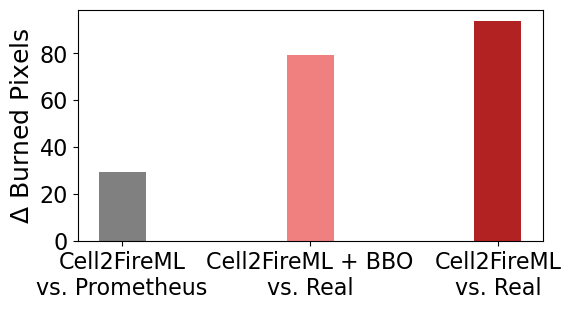

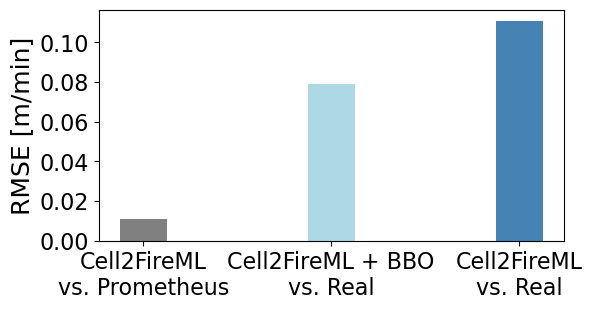

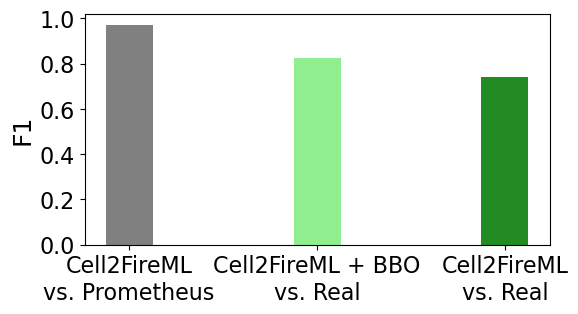

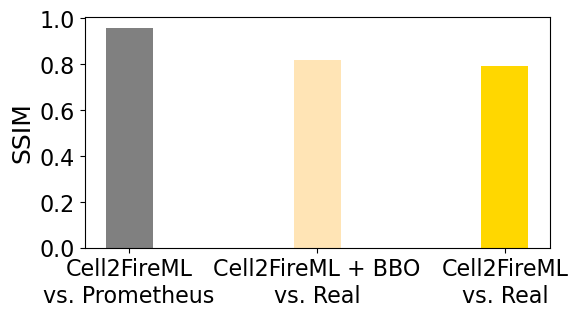

In [21]:
# Plot
vars = ['$\Delta$ Burned Pixels', 'RMSE [m/min]', 'F1', 'SSIM', 'Runtime [s]']
colors = [['gray', 'lightcoral', 'firebrick'], ['gray', 'lightblue', 'steelblue'], ['gray', 'lightgreen', 'forestgreen'], ['gray','moccasin','gold']]
for var, col in list(zip(vars, colors)):

    fig, ax = plt.subplots(1, figsize=(6,3))
    if var is not 'RMSE [m/min]':
        ax.bar(acc_df['Instance'], acc_df[var], color=col, width=0.25)
    else:
        ax.bar(acc_df['Instance'], np.sqrt(acc_df[var]), color=col, width=0.25)
    ax.set_xlabel("")
    ax.set_ylabel(var, size=18)
    ax.set_xticklabels(acc_df['Instance'])

    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.show()

## Chile

In [22]:
# Load real landscape paths
base_data_path = '/Users/minho/Desktop/Cell2FireML/Github/data/real/chile_portuzeuelo'
base_path = '/Users/minho/Desktop/Cell2FireML/Github/plot/results/CHILE'

forest_path = os.path.join(base_data_path, "Forest.asc")
elev_path = os.path.join(base_data_path, "elevation.asc")
slope_path = os.path.join(base_data_path, "slope.asc")
saz_path = os.path.join(base_data_path, "saz.asc")
lcp_lut_path = os.path.join(base_data_path, 'kitral_lookup_table.csv')

In [23]:
# Load images and LUT
forest_data = read_asc_file(forest_path)
forest_img = asc_to_numpy(forest_data)
elev_data = read_asc_file(elev_path)
elev_img = asc_to_numpy(elev_data)
slope_data = read_asc_file(slope_path)
slope_img = asc_to_numpy(slope_data)
saz_data = read_asc_file(saz_path)
saz_img = asc_to_numpy(saz_data)
lut = pd.read_csv(lcp_lut_path)
lut_df = lut[lut['grid_value'].isin(np.unique(forest_img))]

# Reclassify
# Create a custom colormap
lut_df['r'] = [131, 112, 223, 172, 255, 100, 255, 150]
lut_df['g'] = [199, 168, 184, 102, 211, 25, 0, 155]
lut_df['b'] = [149, 0, 230, 237, 127, 50, 50, 150]
lcp_colors = lut_df[['r','g','b']] 
lcp_colors = [(r,g,b) for r,g,b in zip(lut_df['r']/255, lut_df['g']/255, lut_df['b']/255)]
cmap = ListedColormap(lcp_colors, name='cmap', N=8)

# Get a colormap from Matplotlib
results_df = pd.read_csv(os.path.join(base_path, 'summary_results_chile.csv'))
results_df['FTYPE'] = [results_df['Instance'].iloc[i].split('_')[-1] for i in range(len(results_df))]

plot_df = results_df[31:] # Select the 31 homogeneous fuel types 
plot_df['RMSE'] = np.sqrt(plot_df['MSE'])
num_unique_values = len(plot_df['FTYPE'].unique())
colormaps = [sns.color_palette(color, n_colors=num_unique_values) for color in ['Reds', 'Blues', 'Greens', 'Oranges'] ]

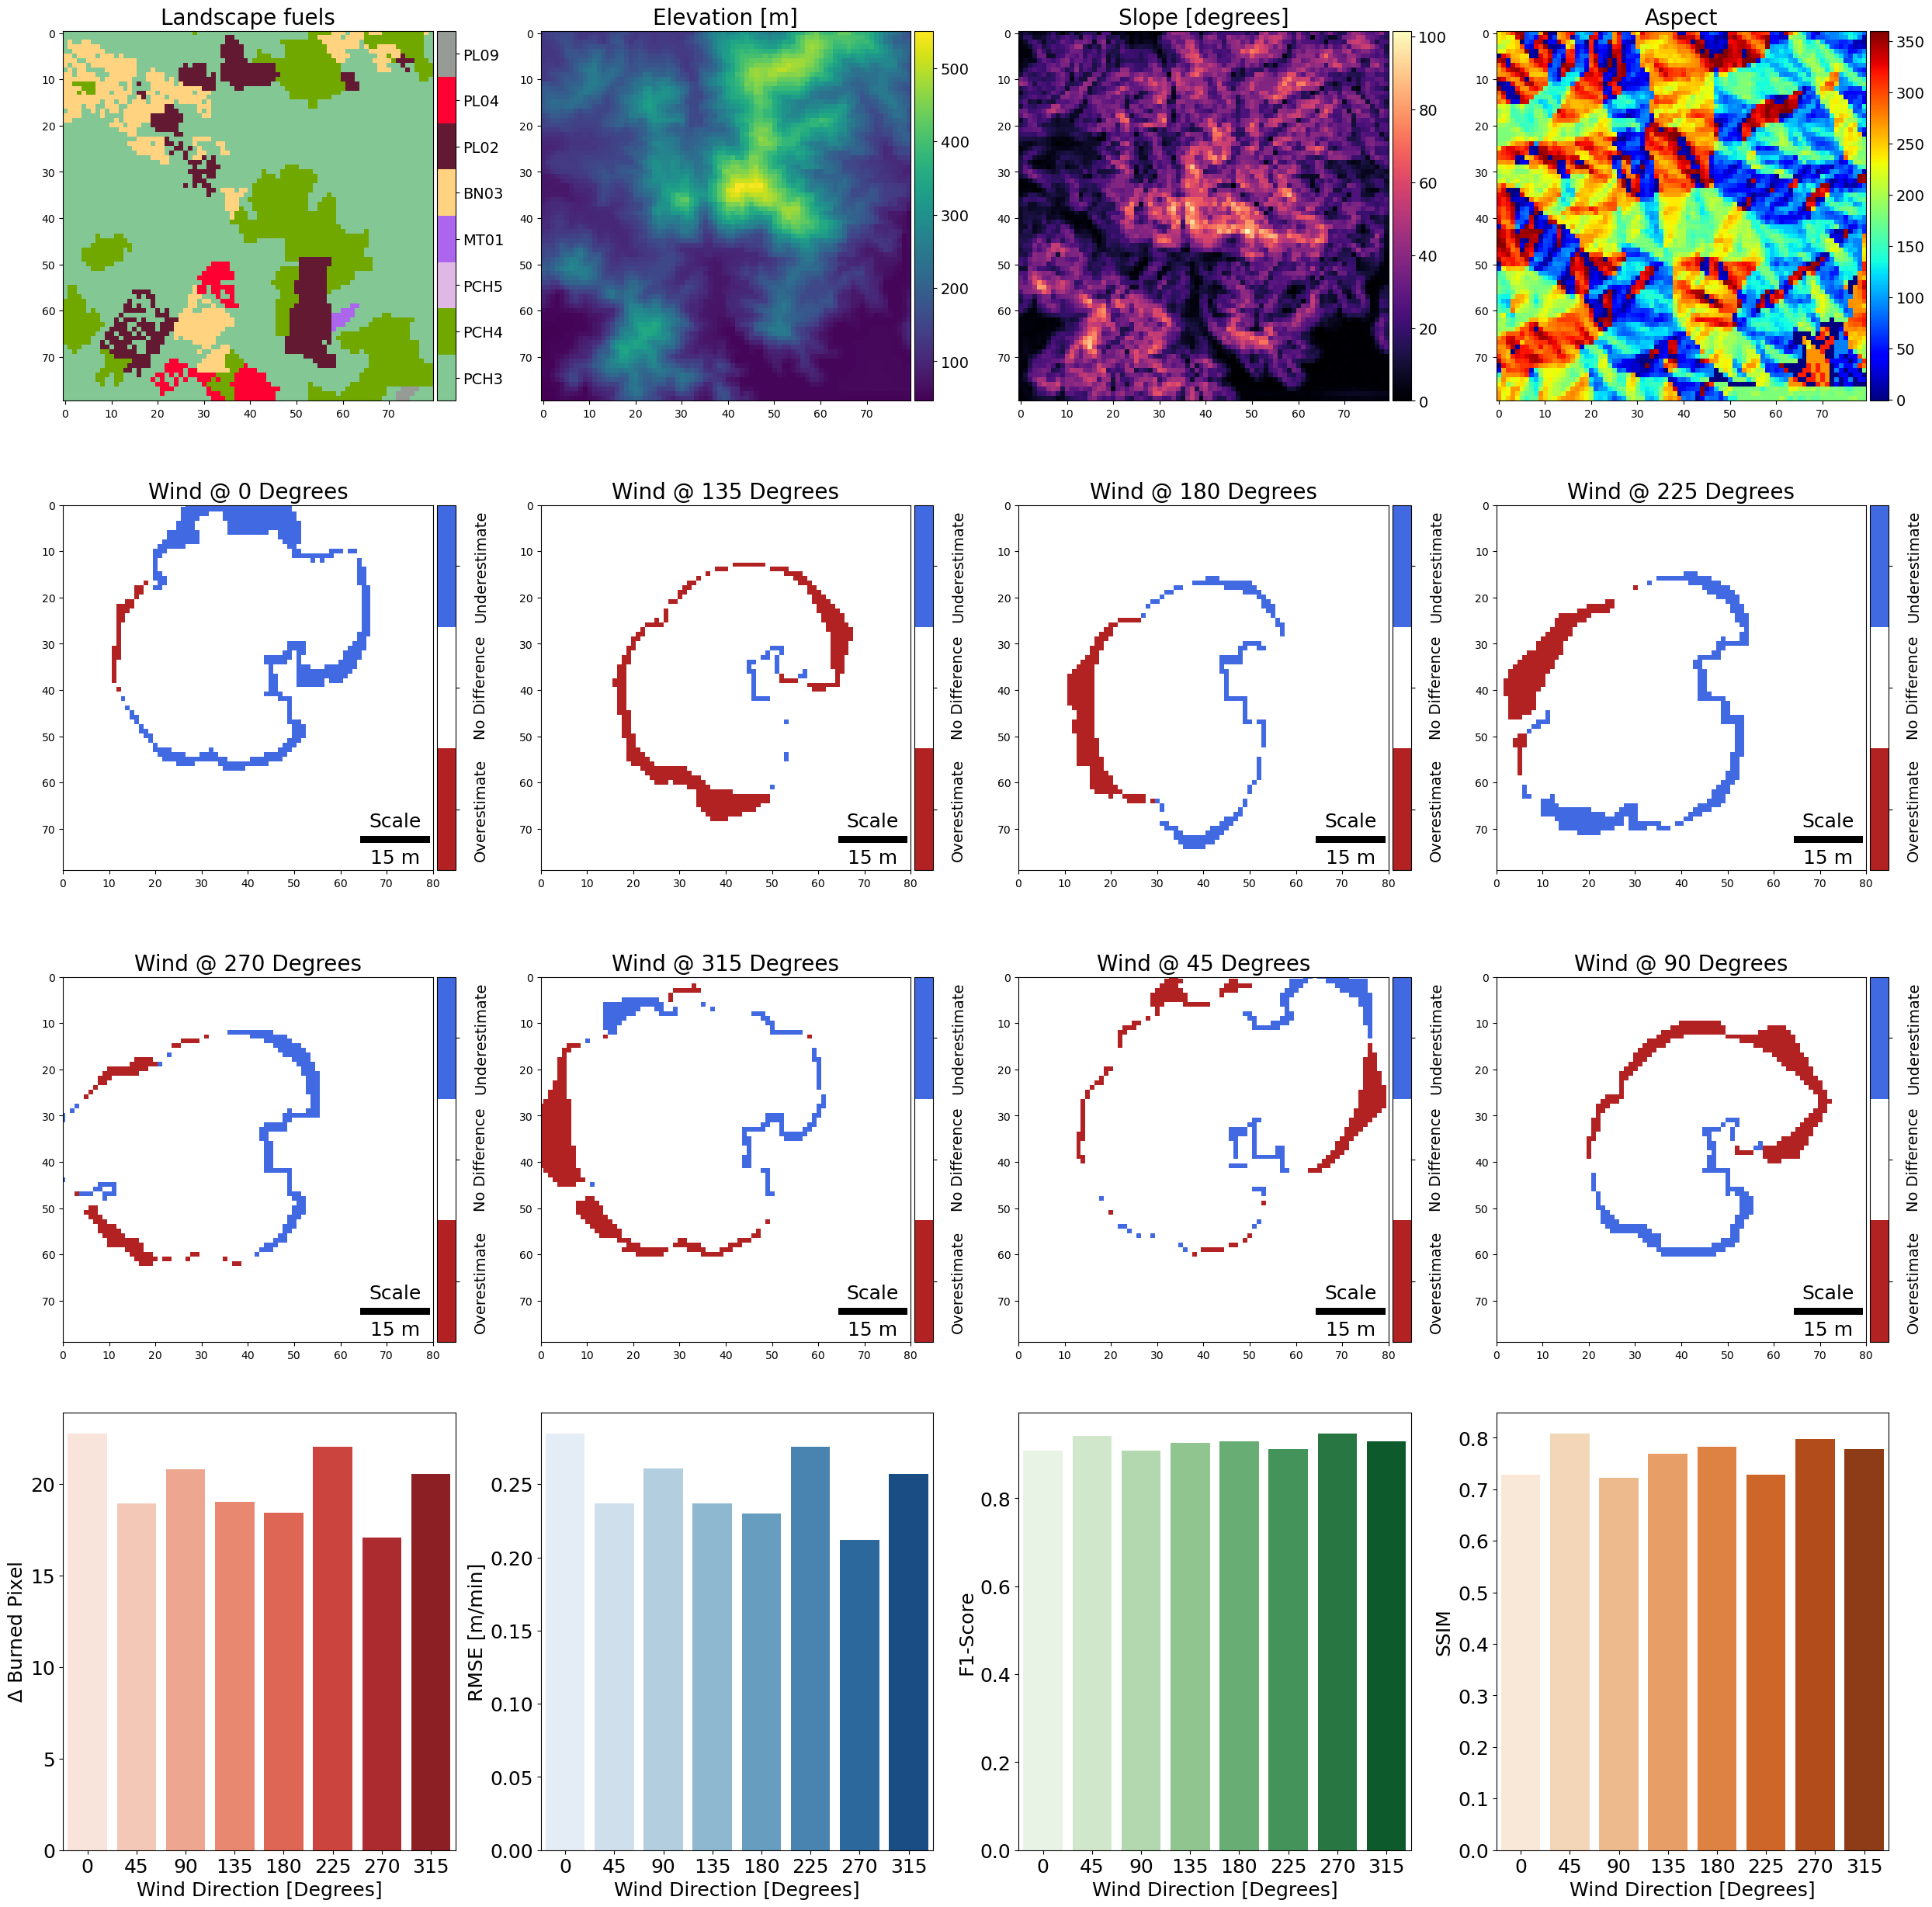

In [24]:
# Plot
fig, ax = plt.subplots(4,4, figsize = (25,25))

# 1. Plot landscape
ax[0,0].imshow(forest_img, cmap=cmap)
ax[0,0].set_title('Landscape fuels', size=20)
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks((np.arange(len(lcp_colors)) + 0.5) / 8)
cbar.set_ticklabels(lut_df['fuel_type'], size=14)
cbar.ax.tick_params(labelsize=14)

# 2. Plot terrain
im2 = ax[0,1].imshow(elev_img, cmap='viridis')
ax[0,1].set_title('Elevation [m]', size=20)
divider2 = make_axes_locatable(ax[0,1])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=im2.norm)
cbar2 = fig.colorbar(sm2, cax=cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=14)

im3 = ax[0,2].imshow(slope_img, cmap='magma')
ax[0,2].set_title('Slope [degrees]', size=20)
divider3 = make_axes_locatable(ax[0,2])
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
sm3 = plt.cm.ScalarMappable(cmap='magma', norm=im3.norm)
cbar3 = fig.colorbar(sm3, cax=cax3, orientation='vertical')
cbar3.ax.tick_params(labelsize=14)

im4 = ax[0,3].imshow(saz_img, cmap='jet')
ax[0,3].set_title('Aspect', size=20)
divider4 = make_axes_locatable(ax[0,3])
cax4 = divider4.append_axes('right', size='5%', pad=0.05)
sm4 = plt.cm.ScalarMappable(cmap='jet', norm=im4.norm)
cbar4 = fig.colorbar(sm4, cax=cax4, orientation='vertical')
cbar4.ax.tick_params(labelsize=14)

# 3. Plot results
cell2fire_paths = sorted(glob.glob(os.path.join(base_path, 'real/cell2fireml_Portezuelo_*')))
kitral_paths = sorted(glob.glob(os.path.join(base_path, 'real/kitral_Portezuelo_*')))

count = 0
for i in range(1,3):
    for j in range(4):
        
        cell2fire_path = cell2fire_paths[count] 
        kitral_path = kitral_paths[count] 
        instance='cell2fireML_kitral'
        title = "Wind @ " + str(cell2fire_path.split('_')[-1].split('.csv')[0]) + " Degrees"

        cell2fire_img = np.asarray(pd.read_csv(cell2fire_path,delimiter=" ") )
        kitral_img = np.asarray(pd.read_csv(kitral_path,delimiter=" "))
        
        grid1=kitral_img; grid2=cell2fire_img; x_size=kitral_img.shape[1]; y_size=kitral_img.shape[0]; fuel_type=None;

        # Plot
        ax[i,j].set_title(title, size=20)
        ax[i,j].set_xlim([0,x_size]); ax[i,j].set_ylim([y_size,0])
        scalebar = ScaleBar(1, 'm', length_fraction=0.2, width_fraction=0.02, frameon=False, location='lower right', label='Scale',font_properties={"size": 18})
        ax[i,j].add_artist(scalebar)
        cmap2 = ListedColormap(['firebrick','white','royalblue'])
        diff = grid1 - grid2
        im = ax[i,j].imshow(diff, cmap=cmap2, interpolation='nearest', vmin=-1, vmax=1)
        
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        sm = plt.cm.ScalarMappable(cmap=cmap2)
        sm.set_clim(-1, 1)  # Set the color limits to match the desired values
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([2/3, 0, -2/3])
        cbar.set_ticklabels(['Underestimate','No Difference','Overestimate'],size=14, ha='center', va='center', rotation=90)  # Set custom tick labels
        cbar.ax.yaxis.set_tick_params(pad=20)

        count+=1

# Plot stats
label_size = 18
sns.barplot(ax=ax[3,0], data=plot_df, x="FTYPE", y="$\delta$ norm", palette=colormaps[0])
ax[3,0].set_xlabel("Wind Direction [Degrees]", size=label_size)
ax[3,0].set_ylabel("$\Delta$ Burned Pixel", size=label_size)
ax[3,0].tick_params(axis='x', labelsize=label_size)  # Adjust xticks size
ax[3,0].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[3,1], data=plot_df, x="FTYPE", y="RMSE", palette=colormaps[1])
ax[3,1].set_xlabel("Wind Direction [Degrees]", size=label_size)
ax[3,1].set_ylabel("RMSE [m/min]", size=label_size)
ax[3,1].tick_params(axis='x', labelsize=label_size)  # Adjust xticks size
ax[3,1].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[3,2], data=plot_df, x="FTYPE", y="F1", palette=colormaps[2])
ax[3,2].set_xlabel("Wind Direction [Degrees]", size=label_size)
ax[3,2].set_ylabel("F1-Score", size=label_size)
ax[3,2].tick_params(axis='x', labelsize=label_size)  # Adjust xticks size
ax[3,2].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[3,3], data=plot_df, x="FTYPE", y="SSIM", palette=colormaps[3])
ax[3,3].set_xlabel("Wind Direction [Degrees]", size=label_size)
ax[3,3].set_ylabel("SSIM", size=label_size)    
ax[3,3].tick_params(axis='x', labelsize=label_size)  # Adjust xticks size
ax[3,3].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

plt.tight_layout()

plt.show()

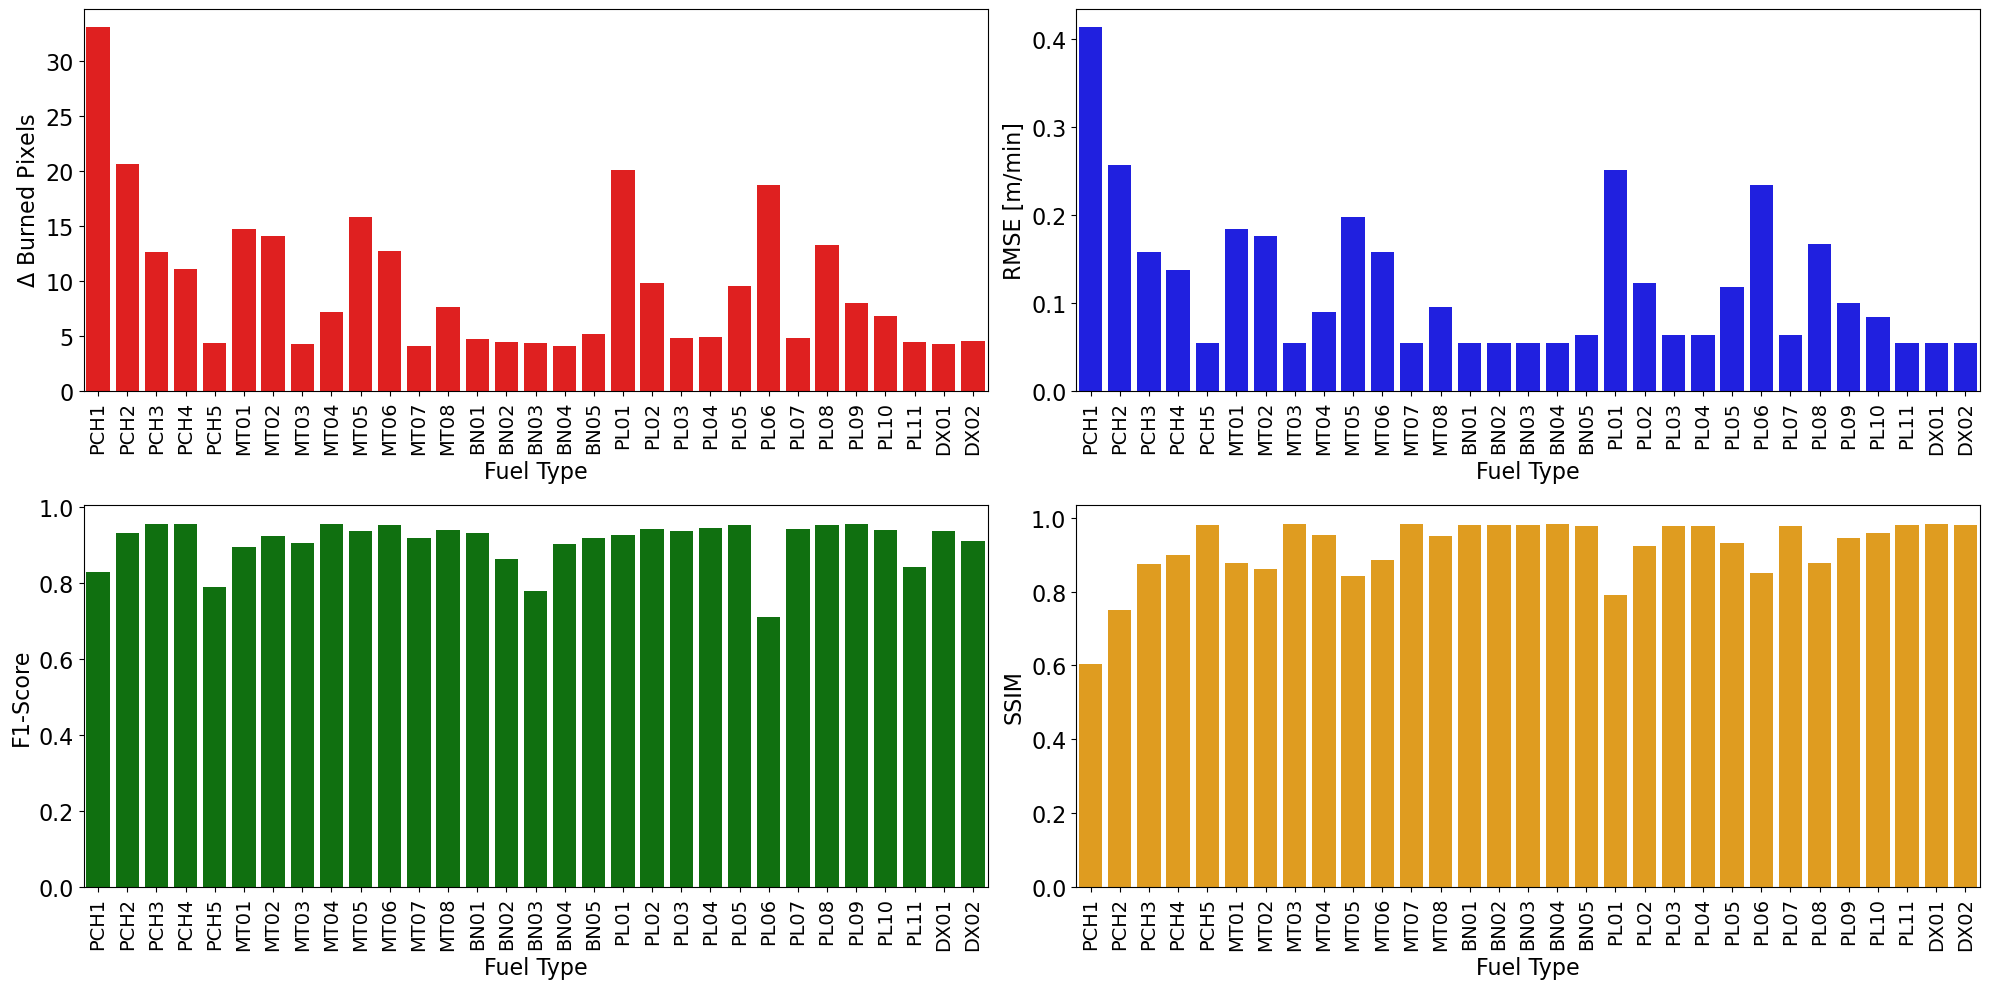

In [ ]:
# Plot error and accuracy results

# Homogeneous
lut['grid_str'] = lut['grid_value'].astype(str)
merged_df = pd.merge(results_df[:31], lut, left_on='FTYPE', right_on='grid_str')
merged_df['RMSE'] = np.sqrt(merged_df['MSE'])
num_unique_values = len(merged_df['FTYPE'].unique())
colormaps = [sns.color_palette(color, n_colors=num_unique_values) for color in ['Reds', 'Blues', 'Greens', 'Oranges'] ]
instance='cell2fireML_kitral_homogeneous'

label_size = 16

# Plot stats
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.barplot(ax=ax[0,0], data=merged_df, x="fuel_type", y="$\delta$ norm", color='red')
ax[0,0].tick_params(axis='x', rotation=90) 
ax[0,0].set_xlabel("Fuel Type", size=label_size)
ax[0,0].set_ylabel("$\Delta$ Burned Pixels", size=label_size)
ax[0,0].tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax[0,0].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[0,1], data=merged_df, x="fuel_type", y="RMSE",color='blue')
ax[0,1].tick_params(axis='x', rotation=90) 
ax[0,1].set_xlabel("Fuel Type", size=label_size)
ax[0,1].set_ylabel("RMSE [m/min]", size=label_size)
ax[0,1].tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax[0,1].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[1,0], data=merged_df, x="fuel_type", y="F1", color='green')
ax[1,0].tick_params(axis='x', rotation=90) 
ax[1,0].set_xlabel("Fuel Type", size=label_size)
ax[1,0].set_ylabel("F1-Score", size=label_size)
ax[1,0].tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax[1,0].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

sns.barplot(ax=ax[1,1], data=merged_df, x="fuel_type", y="SSIM", color='orange')
ax[1,1].tick_params(axis='x', rotation=90) 
ax[1,1].set_xlabel("Fuel Type", size=label_size)
ax[1,1].set_ylabel("SSIM", size=label_size)    
ax[1,1].tick_params(axis='x', labelsize=14)  # Adjust xticks size
ax[1,1].tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

plt.tight_layout()
plt.show()

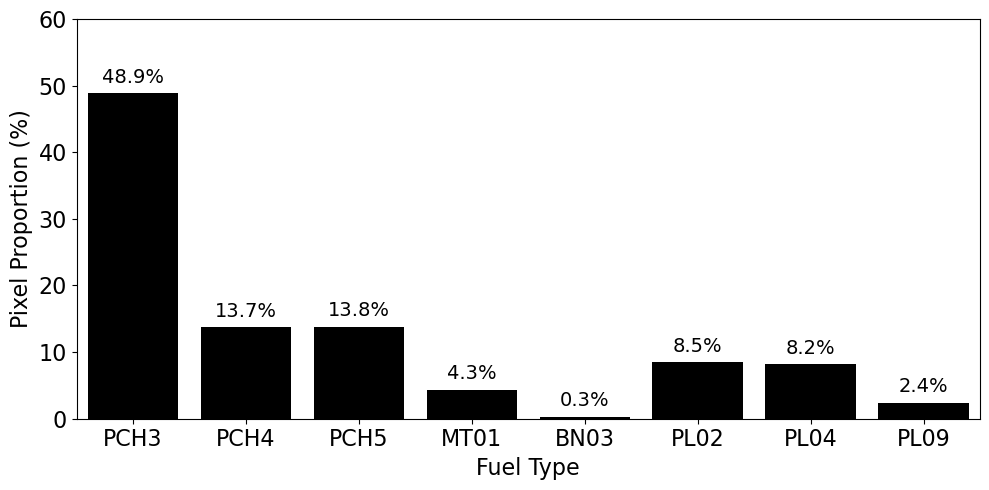

In [ ]:
# Plot data distribution
num, counts = np.unique(forest_img, return_counts=True)
lut_df = lut[lut['grid_value'].isin(np.unique(forest_img))]
lut_df['count'] = counts[1:-1]
lut_df['countp'] = lut_df['count']/sum(lut_df['count'])*100

label_size = 16

fig,ax = plt.subplots(1, figsize=(10,5))

sns.barplot(ax=ax, data=lut_df, x='fuel_type', y='countp', color='black')
ax.set_xlabel("Fuel Type", size=label_size)
ax.set_ylabel("Pixel Proportion (%)", size=label_size)
ax.set_ylim(0,60)
ax.tick_params(axis='x', labelsize=label_size)  # Adjust xticks size
ax.tick_params(axis='y', labelsize=label_size)  # Adjust yticks size

for i, value in enumerate(lut_df['countp']):
    
    value_str = f'{value:.1f}' + '%'  # Convert value to string
    ax.annotate(value_str, xy=(i, value), xytext=(i, value + 1), 
                        ha='center', va='bottom', size=14)

plt.tight_layout()
plt.show()